<a href="https://colab.research.google.com/github/StanStarishko/Portfolio/blob/main/Software_Security_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Software Security Project**


---
*  **Cyber Resilience (SCQF8)**
*  **Software Security (SCQF7)**



---


##**Author:** *Stanislav Starishko*

*  **March 2024**
*  This is my **second *big* experience** with ***Python***
*  and **the first** with ***AWS Lambda, S3*** and ***Google Maps API***



# **Brief, User Stories and Solution design**


---



##**The Problem**

When people need to relocate to a new area, they may need to find schools within a reasonable distance of where they would live. This might determine their choice of location.   If the process was automated, it would be quick to use and the information could come from one place, rather than several places.

Potentially, if a list could be stored, it could be edited to reduce the list to a selection of schools that might be used in decision-making about where to locate.

##**User Stories**

###***Story \#1***


---


* **AS** a user
* **WHEN** I want to find the nearest schools to a given location
* **THEN** I will be able to run a function in a Google Colab that will ask Google Maps to send a list of nearby schools
* **AND** I will be shown a list of schools in that area
* **AND** this information will also be sent to a serverless function on AWS and saved in schools file on S3


---



###***Story \#2***


---


* **AS** a user
* **WHEN** I want to see all the schools in the file on AWS S3
* **THEN** I will be able to run a function in a Google Colab that will send a request to get the full list,
* **AND** I will see the list printed in my output


---






## **Solution design**

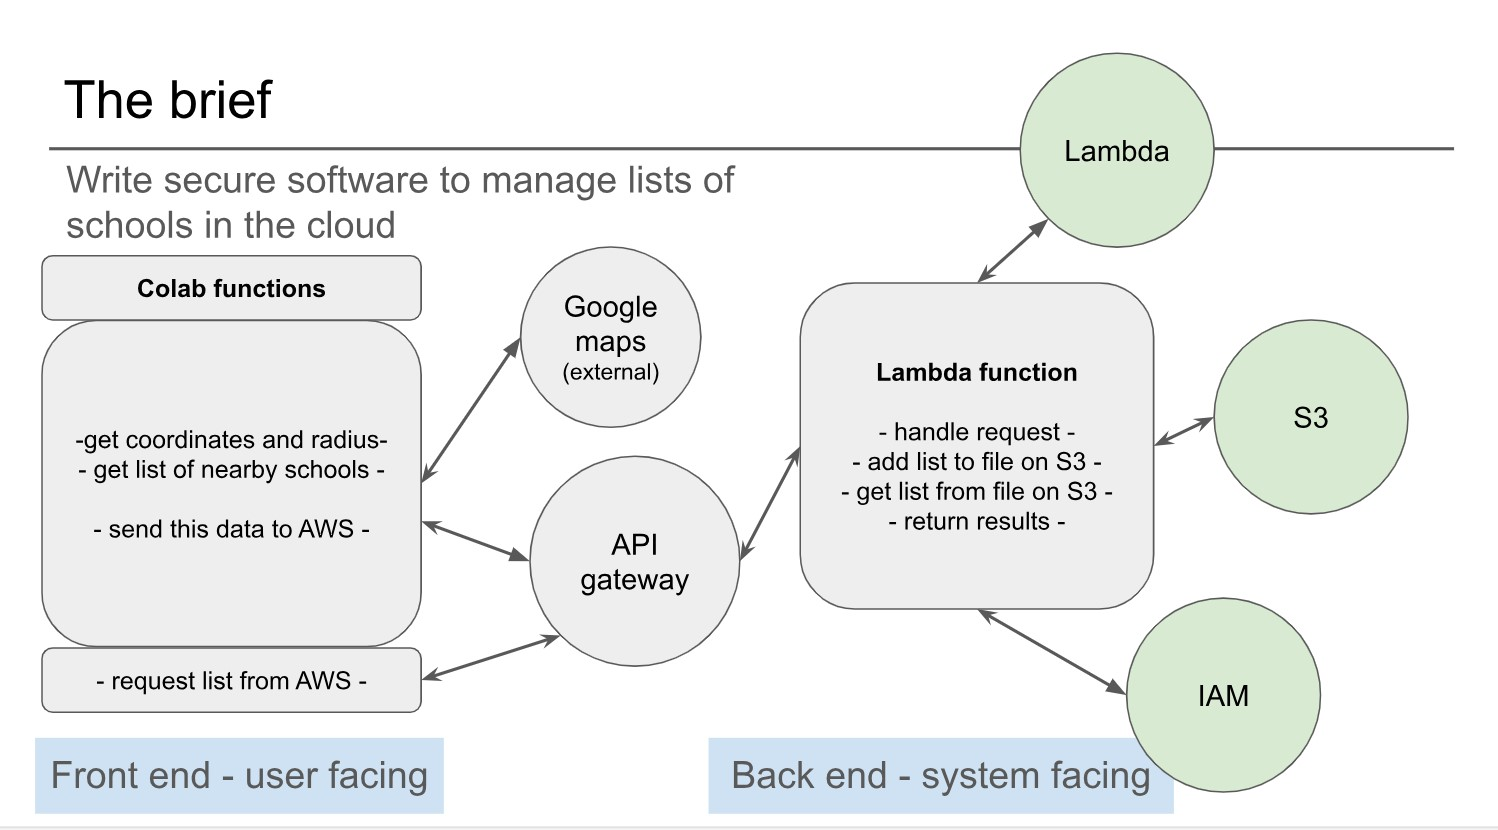

#**Technical Requirements**

**User function - in Google Colab**
*   Function should run in a Google Colab
*   API keys and any other sensitive data must NEVER be exposed (at any point during the design, development, testing or deployment phases)


**API function - in AWS Lambda**
*   Must be secured
*   Will receive data
*   Will accept a list of schools and add them to a database or file
*   Will accept a name of a school to delete from the file on S3
*   Will return a list of all schools in the database or file on request
*   Will return a success status and message after adding or deleting.
*   Will return an error status and message on encountering a problem
*   Will always return success or error


#**Threat Modelling**

##Here is the table describing the potential threats and problems along with their risk levels, suggested mitigations, and the remaining risk levels after applying the mitigations:

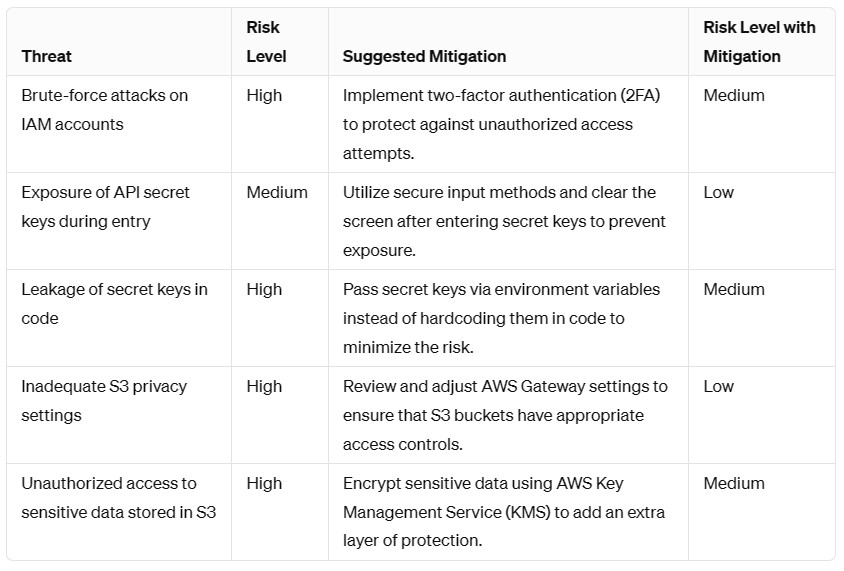





## Below, the above table as a list form:

- **Threat:** ***Brute-force attacks on IAM accounts***
  - **Risk Level:** *High*
  - **Suggested Mitigation:** Implement two-factor authentication (2FA) to protect against unauthorized access attempts.
  - **Risk Level with Mitigation:** ***Medium***

- **Threat:** ***Exposure of API secret keys during entry***
  - **Risk Level:** *Medium*
  - **Suggested Mitigation:** Utilize secure input methods and clear the screen after entering secret keys to prevent exposure to unauthorized users.
  - **Risk Level with Mitigation:** ***Low***

- **Threat:** ***Leakage of secret keys in code***
  - **Risk Level:** *High*
  - **Suggested Mitigation:** Pass secret keys via environment variables instead of hardcoding them in code to minimize the risk of exposure.
  - **Risk Level with Mitigation:** ***Medium***

- **Threat:** ***Inadequate S3 privacy settings***
  - **Risk Level:** *High*
  - **Suggested Mitigation:** Review and adjust AWS Gateway settings to ensure that S3 buckets have appropriate access controls to protect sensitive data.
  - **Risk Level with Mitigation:** ***Low***

- **Threat:** ***Unauthorized access to sensitive data stored in S3***
  - **Risk Level:** *High*
  - **Suggested Mitigation:** Encrypt sensitive data using AWS Key Management Service (KMS) to add an extra layer of protection against unauthorized access.
  - **Risk Level with Mitigation:** ***Medium***

##**Summarizing**

###To minimize cyber risks and enhance the cyber resilience of my application, I implemented the following measures:

#### - Configured two-factor authentication for IAM

#### - Implemented automatic clearing of the terminal window after entering API secret keys for Lambda functions and Google Maps API

#### - Ensured that secret keys are stored only in environment variables and not within the application, and are passed directly to API requests

#### - Specified all confidentiality settings for accessing the S3 bucket in the AWS Gateway confidentiality settings

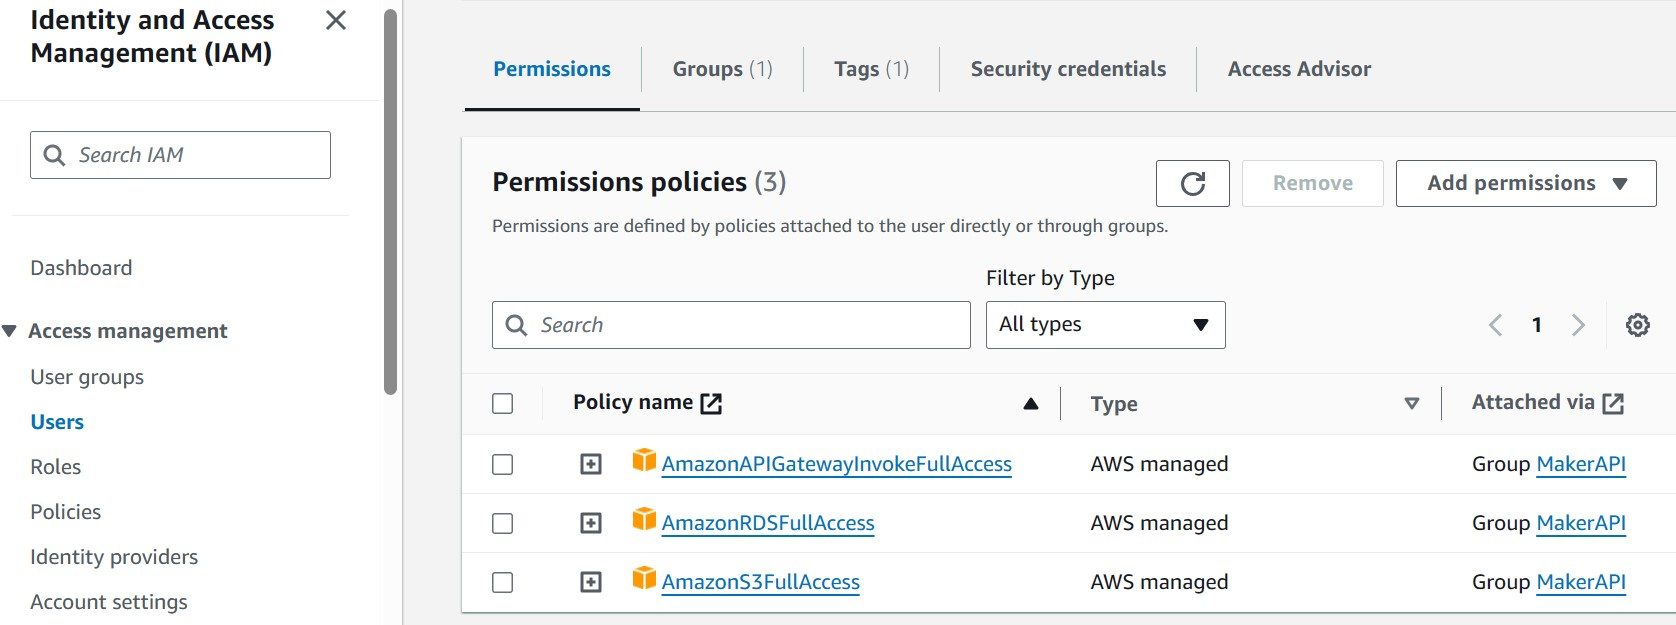


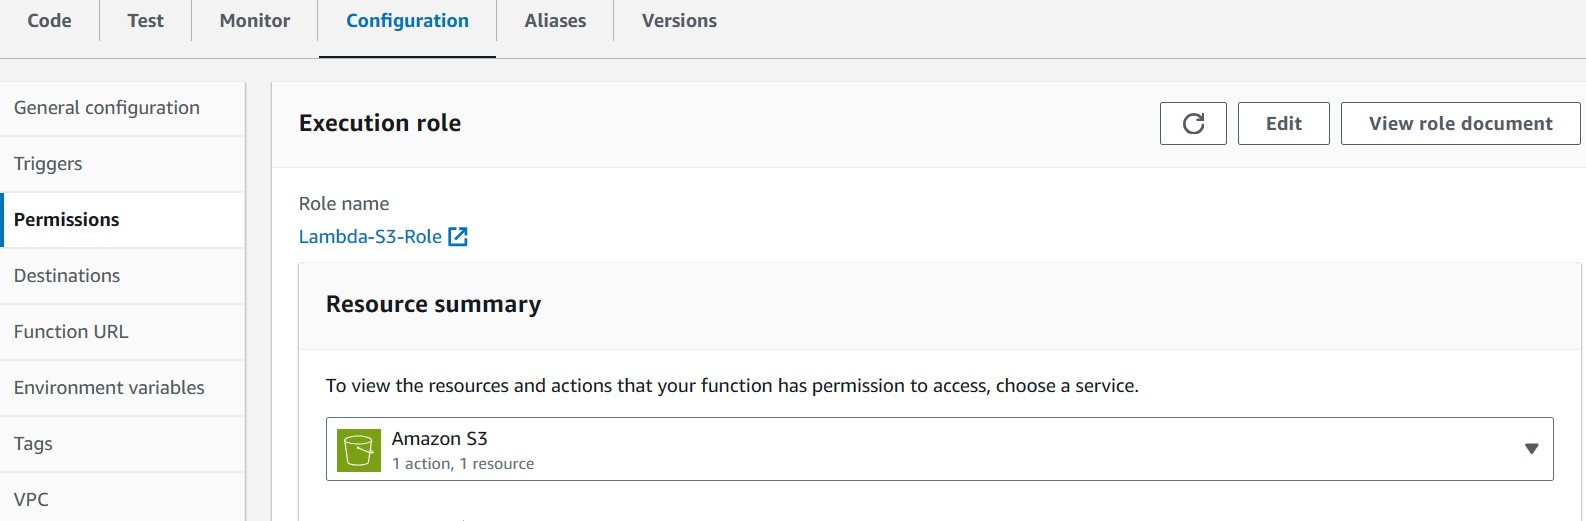


#### - Defined basket identifiers and file names for storing the school list in the AWS Gateway environment settings

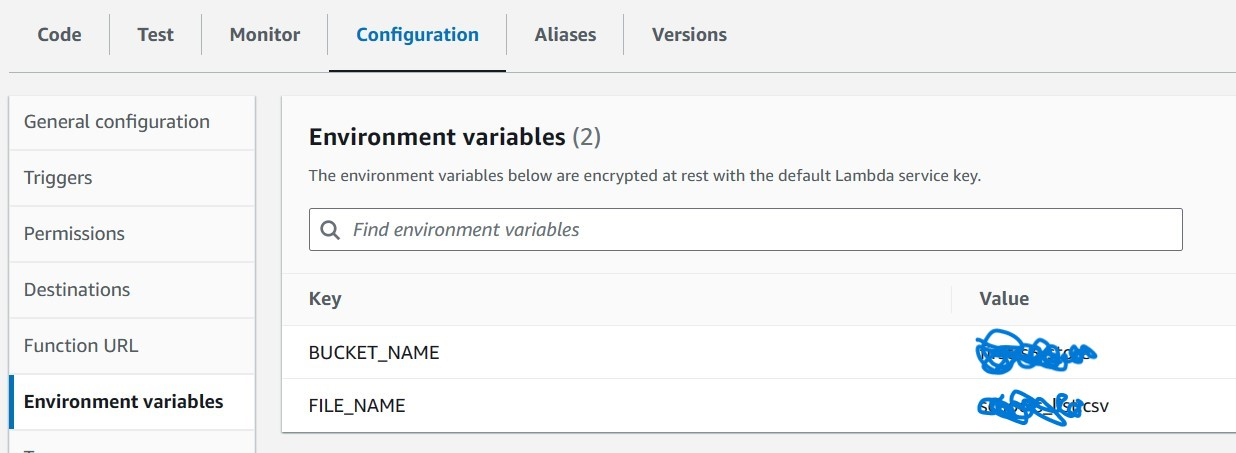


#**Design, develop, test and document a software solution**

##**Design**

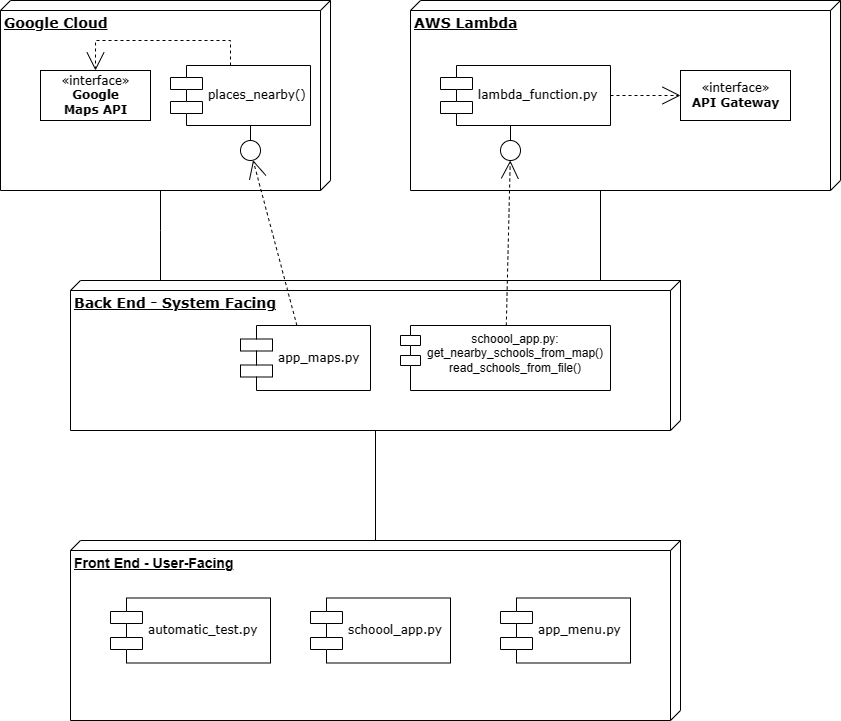

##**Develop**

###**AWS Lambda, S3**

#### **\_\_init__.py**

Just the empty file

#### **functions.py**

#####AWS Lambda handler script



```
## functions.py
#pip install boto3

import os

import boto3


# creates an S3 client
def get_S3_client():
  resource = boto3.client("s3")
  return resource


#gets the object from the bucket
def get_file():
  # get the file from the bucket
  s3_client = get_S3_client()

  bucket_name = os.environ.get("BUCKET_NAME")
  file_name = os.environ.get("FILE_NAME")

  #code for testing
  #bucket_name = "No name"
  #file_name = "No name"

  error_code = 200
  error_descript = ""

  if bucket_name is None:
    error_code = 422
    error_descript = "bucket name is not set"

  if file_name is None:
    error_code = 422
    prefix_error = "" if error_code == 200 else " and "
    error_descript += prefix_error + "flie name is not set"

  if error_code == 422:
    return error_code, error_descript

  try:
    file_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
  except Exception as e:
    error_descript += "Unable to get the file (specified key) "
    error_descript += f"{file_name} from the bucket {bucket_name} with error: {e}"
    return 422, error_descript

  #read the data from the file object and decode it from bytes data to string data
  data_file = file_object["Body"].read()
  return error_code, str(data_file.decode("utf-8"))


#puts the data to the bucket file
def put_file(data_sream):
  s3 = get_S3_client()

  bucket_name = os.environ.get("BUCKET_NAME")
  file_name = os.environ.get("FILE_NAME")

  #code for testing
  #bucket_name = "No name"
  #file_name = "No name"

  error_code = 200
  error_descript = ""

  if bucket_name is None:
    error_code = 422
    error_descript = "bucket name is not set"

  if file_name is None:
    error_code = 422
    prefix_error = "" if error_code == 200 else " and "
    error_descript += prefix_error + "flie name is not set"

  if error_code == 422:
    return error_code, error_descript

  response = s3.put_object(Bucket=bucket_name,
                           Key=file_name,
                           Body=data_sream)

  return error_code, response

```



#### **lambda_function.py**

##### Lambda function script



```
# lambda_function.py

# handle the request, passing the data to other functions

import json

from functions import get_file, put_file

#from functions import get_file  #, get_statuscode
def lambda_handler(event, context):
  if "body" in event.keys():
    data = event["body"]
    if type(data) is not dict:
      data = json.loads(data)
    #check the need keys
    if "action" in data.keys():
      action = data["action"]
      if action == "get_file":
        statuscode, return_data = get_file()

      elif action == "put_file":
        if "data_stream" in data.keys():
          statuscode, return_data = put_file(data["data_stream"])

        else:
          statuscode = 400
          return_data = "Cloud API error: data_stream is not set"

      else:
        statuscode = 400
        return_data = "Cloud API error: Invalid action"
        
    else:
      statuscode = 422
      return_data = "Cloud API error: Invalid parameters"
      
  else:
    return_data = "Unable to get Body data"
    statuscode = 404

  # now it can return the result in a JSON object with some security settings in the headers
  return {
      'statusCode':
      statuscode,
      'headers': {
          'Content-Type': 'application/json',
          'Access-Control-Allow-Headers': 'Content-Type,X-Api-Key',
          'Access-Control-Allow-Methods': 'POST',
          'Access-Control-Allow-Origin': '*'
      },
      'body':
      json.dumps(return_data)
      if not isinstance(return_data, str) else return_data
  }

```



###**Section for loading libraries and frameworks:**

In [ ]:
!pip install geopy
!pip install googlemaps


### Module for working with **Google maps API**:

In [ ]:
# app_maps.py
#pip install googlemaps

import os
from IPython.display import clear_output
import googlemaps


# get API key and put it in the environment variable
def get_api_key(id_key="GMAPS_API_KEY"):
  input_message = f"Enter your {id_key}: "
  api_key = input(f"{input_message}")
  os.environ[f"{id_key}"] = api_key
  clear_terminal_ascii()
  print(f"\033[32mAPI key saved successfully!\033[0m")


#creats the Gooogle Maps client
def get_google_maps_client(is_auto_test=False):
  if os.environ.get("GMAPS_API_KEY") is None and not is_auto_test:
    get_api_key()

  try:
    #return googlemaps.Client(key=os.environ.get("GMAPS_API_KEY"))
    return googlemaps.Client(key=os.environ.get("GMAPS_API_KEY"))
  except googlemaps.exceptions.HTTPError as e:
    return f"Google Maps HTTP error: {e}"
  except googlemaps.exceptions.ApiError as e:
    return f"Google Maps API error: {e}"
  except Exception as e:
    return f"Google Maps API creates a connection error: {e}"


#clear terminal sreen
def clear_terminal_ascii():
  #print("\033c", end="", flush=True)
  clear_output()


class HandlingMaps:

  def __init__(self, is_auto_test=False):
    self.client = get_google_maps_client(is_auto_test)

  def get_user_location(self):
    while True:
      user_location = input(
          "Enter the coordinates (e.c. 55.816555,-4.309890): ")
      return user_location

  def get_radius(self):
    while True:
      radius = input("Enter the radius in meters (e.c. 500): ")
      if radius.isdigit():
        return int(radius)

      else:
        print("\033[31;1mInvalid choice. Please try again.\033[0m")

  def get_mask(self):
    while True:
      mask = input("Enter the mask (e.c. primary school): ")
      if mask.isdigit():
        return int(mask)

      else:
        print("\033[31;1mInvalid choice. Please try again.\033[0m")

  def get_nearby_schools(self, user_location=None, radius=500, mask=None):
    if user_location is None:
      user_location = self.get_user_location()

    if mask is None:
      mask = ""

    if self.client is None:
      return "Google Maps API error: connectoin is not avaliable"

    try:
      nearby_schools = self.client.places_nearby(location=user_location,
                                                 radius=radius,
                                                 type="school",
                                                 keyword=mask)

      return nearby_schools

    except googlemaps.exceptions.HTTPError as e:
      return f"Google Maps HTTP error: {e}"
    except googlemaps.exceptions.ApiError as e:
      return f"Google Maps API error: {e}"
    except Exception as e:
      return f"Google Maps API creates a connection error: {e}"


### **Module for building and displaying menus:**

In [ ]:
# app_menu.py


class AppMenu:

  def __init__(self, app_name=None, menu_items=None):
    self.app_name = app_name
    self.menu_items = menu_items

  def __setattr__(self, name, value):
    if name == "app_name":
      self.__dict__[name] = str(
          value
      ) if value is not None else "Application - " "List of nearby schools" ""

    elif name == "menu_items":
      self.__dict__[name] = value if value is not None and isinstance(
          value, list) else [
              "Setting Google Maps API key", "Set cloud API key",
              "Getting nearby schools from the Map",
              "Reading saved schools from the file", "Automated testing",
              "Exit"
          ]

    else:
      self.__dict__[name] = value

  def show_menu(self, is_auto_test=False):
    if is_auto_test:
      return

    print(f"\033[34mWelcome to {self.app_name}!\033[22m\033[0m")
    print("Please select an option:")
    for num_item, item in enumerate(self.menu_items):
      print(f"{num_item+1}.  {item}")

  def get_user_choice(self):
    choice = input("Enter your choice: ")
    return choice

  def handle_user_choice(self, choice):
    if choice.isdigit() and int(choice) in range(1, len(self.menu_items) + 1):
      choice_index = int(choice) - 1
      return f"{choice_index+1}.  {self.menu_items[choice_index]}"
    else:
      return "Invalid choice. Please try again."

  def pause_menu(self, is_auto_test=False):
    if is_auto_test:
      return

    input("Press Enter to continue... ")


### **Automatic testing module:**

In [ ]:
#automatic_test.py


#processing resalt execute function
def execute_function_processing(param):
  return_value = 0
  param = param.lower()
  # if isinstance(param, float):
  #   if param < 0: return_value = 1

  if isinstance(param, bool):
    return_value = int(not param)

  if isinstance(param, str):
    list_err = ("not", "err", "wrong")
    for cur_err in list_err:
      if param.find(cur_err) >= 0: return_value = 1

  return return_value


#execute function in the processing
def execute_function(descript_test, func, *args):
  try:
    execute_result = func(*args)
    with_err = execute_function_processing(execute_result)
    if with_err == 0:
      print(
          f"{descript_test} for \033[34m\"{func.__name__}\" \033[36mexecuted successfully\033[0m"
      )
    else:
      print(
          f"{descript_test} for \033[34m\"{func.__name__}\" \033[31mwrong executed: {execute_result}\033[0m"
      )
    #total, crashes, errors
    return 1, 0, with_err
  except TypeError:
    print(
        f"{descript_test} for \033[34m\"{func.__name__}\" \033[91mcrashed with with wrong type some kind of param\033[0m"
    )
    #total, crashes, errors
    return 1, 1, 0
  except Exception as err:
    print(
        f"{descript_test} for \033[34m\"{func.__name__}\" \033[91mcrashed with error(s): {err}\033[0m"
    )
    #total, crashes, errors
    return 1, 1, 0


#processing the prepared tests
#total, crashes, errors
#tuple_tests = (0, 0, 0)
def test_processing(exec_params=None, tuple_tests=(0, 0, 0)):
  if exec_params is None:
    exec_params = prepare_prarams_data_test()

  for cur_process in exec_params:
    descript_test = cur_process[0]
    func = cur_process[1]
    if len(cur_process) > 2:
      args = cur_process[2:]
      tuple_tests = tuple(a + b for a, b in zip(
          tuple_tests, execute_function(descript_test, func, *args)))

    else:
      tuple_tests = tuple(
          a + b
          for a, b in zip(tuple_tests, execute_function(descript_test, func)))

  return tuple_tests


#prepare the tests
def prepare_prarams_data_test():
  params_test = []
  #test for get_data()
  params_test.append(["test without data parameters", get_data, db_conn])
  #test for get_user_data()
  params_test.append(
      ["test with normal data parameters", get_user_data, 1, db_conn])
  params_test.append(
      ["test with abnormal data parameters", get_user_data, 15, db_conn])
  params_test.append(
      ["test with extreme data parameters", get_user_data, "15", "db_conn"])
  #test for add_new_user()
  params_test.append(
      ["test with normal data parameters", add_new_user, 11, db_conn])
  params_test.append(
      ["test with abnormal data parameters", add_new_user, 1, db_conn])
  params_test.append(
      ["test with extreme data parameters", add_new_user, 12.5, db_conn])
  params_test.append(
      ["test with extreme data parameters", add_new_user, "15", "db_conn"])
  #test for remove_user()
  params_test.append(
      ["test with normal data parameters", remove_user, 7, db_conn])
  params_test.append(
      ["test with abnormal data parameters", remove_user, 12.5, db_conn])
  params_test.append(
      ["test with extreme data parameters", remove_user, "15", "db_conn"])
  #test for add_funds()
  params_test.append(
      ["test with normal data parameters", add_funds, 2, 15, db_conn])
  params_test.append(
      ["test with abnormal data parameters", add_funds, 2, -100, db_conn])
  params_test.append([
      "test with extreme data parameters", add_funds, "15", "-100", "db_conn"
  ])
  #test for remove_funds()
  params_test.append(
      ["test with normal data parameters", remove_funds, 1, 44, db_conn])
  params_test.append(
      ["test with abnormal data parameters", remove_funds, 1, 100, db_conn])
  params_test.append([
      "test with extreme data parameters", remove_funds, "15", "1000",
      "db_conn"
  ])

  return params_test




---



---


###**Main application script:**


---


---




In [ ]:
#schoool_app.py
#pip install geopy.distance

import csv
import os
from io import StringIO

import requests
from geopy.distance import geodesic
from tabulate import tabulate

# from app_maps import HandlingMaps, clear_terminal_ascii, get_api_key
# from app_menu import AppMenu
# from automatic_test import test_processing


#handle Google Maps API response
def handle_map_response(response, user_location, is_auto_test=False):
  if not isinstance(response, dict):
    return f"Google Maps API response error is not a dictionary: {response}"

  if len(response["results"]) == 0:
    return f"Google Maps API response error: results is an empty list: {response}"

  if "status" not in response:
    return f"Google Maps API response error: status is not in the response: {response}"

  if response["status"] != "OK":
    return f"Google Maps API response error: status is not OK: {response}"

  if not isinstance(response["results"], list):
    return f"Google Maps API response error: results is not a list: {response}"

  clear_places = [
      {
          "name": place["name"],
          "address": place["vicinity"],
          "distance": get_distance(user_location, place["geometry"]["location"])
      } for place in response["results"]
  ]

  if not is_auto_test:
    print(f"\033[36m{len(clear_places)} schools found!\033[0m")
    print(
        tabulate(clear_places, headers="keys", tablefmt="grid",
                 showindex=True))

  return clear_places


#get distance between two points
def get_distance(point1, point2):
  point2 = str(point2["lat"]) + "," + str(point2["lng"])
  return f"{geodesic(point1,point2).kilometers:.2f}"


#get nearby schools from map
def get_nearby_schools_from_map(is_auto_test=False, user_location=True, radius=True):
  map_connector = HandlingMaps(is_auto_test)

  #API connect with any error
  if isinstance(map_connector.client, str):
    return map_connector.client

  #get user location
  if isinstance(user_location, bool):
    user_location = map_connector.get_user_location()

  #get radius
  if isinstance(radius, bool):
    radius = map_connector.get_radius()

  #get nearby schools from map
  response = map_connector.get_nearby_schools(user_location, radius)
  dict_schools = handle_map_response(response, user_location, is_auto_test)

  if isinstance(dict_schools, str):
    return dict_schools

  #saviing schools to the file on the S3
  if is_auto_test:
    return save_schools_to_file(dict_schools, is_auto_test)

  else:
    if ask_user("Do you want to save the schools to the file? (y/n): ",("y","n"), bool):
      return save_schools_to_file(dict_schools)


#save schools to file on S3
def save_schools_to_file(schools, is_auto_test=False):
  if not is_auto_test:
    set_cloud_api_key()
    print("Saving schools to the file on cloude...")

  #get the CSV dump for saving to the bucket
  csv_buffer = StringIO()

  #We write the dictionary in CSV to a virtual file
  #header_keys = schools[0].keys() #list(schools[0].keys())
  csv_writer = csv.DictWriter(csv_buffer, fieldnames=schools[0].keys())
  csv_writer.writeheader()
  csv_writer.writerows(schools)

  #Getting the contents of the virtual file as a string
  csv_content = csv_buffer.getvalue()

  #saving the Dump to the bucket by AWS Lamda
  api_url = "https://lfops3aao6.execute-api.eu-north-1.amazonaws.com/test/first-s3"
  payload = {"action" : "put_file",
             "data_stream" : csv_content}

  try:
    response = requests.post(api_url,
                            headers={"Content-Type":
                                          "application/json",
                                      "x-api-key":
                                          str(os.environ.get("CLOUD_API_KEY"))},
                            json=payload)

    if response.status_code == 200:
      return_message = "Schools saved on S3 successfully"

    else:
      err_resp = response.json.load()["body"]
      return_message = f"Error saving the schools to the file on S3: {err_resp}"

    return return_message

  except requests.exceptions.RequestException as e:
    return f"Error saving the schools to the file on S3: {e}"

  except Exception as e:
    return f"Error saving the schools to the file on S3: {e}"


#ask user samethngs with/without answering
#answer_options = ["y", "n"] or ("y", "n") or ["y"] or ("y")
def ask_user(question, answer_options=None, answer_type=bool):
  while True:
    user_answer = input(f"{question}").lower()

    #it was just a message to user
    if answer_options is None:
      return True

    else:
      #converting answer to low case
      answer_options = tuple(element.lower()
                             if isinstance(element, str)
                             else str(element).lower()
                             for element in answer_options)

      #check if answer is in answer_options
      if checking_answer(user_answer, answer_options):
        if answer_type == bool:
          return answer_options.index(user_answer) == 0

        else:
          return user_answer

      #if answer is not in answer_options
      else:
        print("\033[31;1mInvalid choice. Please try again.\033[0m")


#checking answer
def checking_answer(user_answer, answer_options):
  return user_answer in answer_options


#get data from the file on S3
def read_schools_from_file(is_auto_test=False):
  if not is_auto_test:
    set_cloud_api_key()
    print("Reading schools from the file on S3...")

#Getting the contents of the virtual file as a string
  api_url = "https://lfops3aao6.execute-api.eu-north-1.amazonaws.com/test/first-s3"
  payload = {"action" : "get_file"}

  try:
    response = requests.post(api_url,
                             headers={"Content-Type":
                                           "application/json",
                                       "x-api-key":
                                           str(os.environ.get("CLOUD_API_KEY"))},
                             json=payload)
    if response.status_code == 200:
      csv_dump = StringIO(response.text)
      clear_places = list(csv.DictReader(csv_dump))
      if not is_auto_test:
        print(f"\033[36m{len(clear_places)} schools were saved on S3:\033[0m")
        print(
            tabulate(clear_places, headers="keys", tablefmt="grid",
                     showindex=True))

      return "Read data from S3 is successfully"

    else:
      err_resp = response.json.load()["body"]
      return f"Error reading the schools from the file on S3: {err_resp}"

  except requests.exceptions.RequestException as e:
    return f"Error reading the schools from the file on S3: {e}"

  except Exception as e:
    return f"Error reading the schools from the file on S3: {e}"


#Menu auomated testing
def menu_auto_test():
  print("Testing the app_menu.py module...\n")
  tuple_tests = (0, 0, 0)

  #noraml data
  try:
    app_menu_test = AppMenu("Schools App (Auto Test)", ["Menu Test Point 1",
                                            "Menu Test Point 2",
                                            "Menu Test Point 3",
                                            "Menu Test Point 4",
                                            "Menu Test Point 5"])

    app_menu_test.show_menu()
    print("Testing the app_menu.py module with normal data... OK\n")
    tuple_tests = (tuple_tests[0] + 1, tuple_tests[1], tuple_tests[2])

  except Exception as e:
    print(f"Error in the app_menu.py module: {e}")
    tuple_tests = (tuple_tests[0], tuple_tests[1] + 1, tuple_tests[2])

  #abnormal data
  try:
    app_menu_test = AppMenu(1234535.456456, [983465876453,
                                            876345.6578,
                                            9876435.34,
                                            -987234876.56,
                                            -976554])

    app_menu_test.show_menu()
    print("Testing the app_menu.py module with abnormal data... OK\n")
    tuple_tests = (tuple_tests[0] + 1, tuple_tests[1], tuple_tests[2])

  except Exception as e:
    print(f"Error in the app_menu.py module: {e}")
    tuple_tests = (tuple_tests[0], tuple_tests[1] + 1, tuple_tests[2])

  #extrime data
  try:
    app_menu_test = AppMenu(["Extrim data test menu", "Second subj"],
                                        34545345)

    app_menu_test.show_menu()
    print("Testing the app_menu.py module with extrim data... OK\n")
    tuple_tests = (tuple_tests[0] + 1, tuple_tests[1], tuple_tests[2])

  except Exception as e:
    print(f"Error in the app_menu.py module: {e}")
    tuple_tests = (tuple_tests[0], tuple_tests[1] + 1, tuple_tests[2])

  return tuple_tests


#prepare tests parameters with wrong API keys
def prepare_wrong_api_tests_parameters():
  params_test = []

  #deleted all API keys
  os.environ.pop("GMAPS_API_KEY", None)
  os.environ.pop("CLOUD_API_KEY", None)

  #reads without API keys
  params_test.append([
    "Reads schools wtthout API key",
    read_schools_from_file,
    True
  ])

  #saves without API keys
  params_test.append([
    "Saves schools wtthout API key",
    get_nearby_schools_from_map,
    True,
    "55.816555,-4.309890",
    1200
  ])

  #set wrong API keys
  os.environ["GMAPS_API_KEY"] = "wrong_api_key"
  os.environ["CLOUD_API_KEY"] = "wrong_api_key"


  #reads with wrong API keys
  params_test.append([
    "Reads schools wtth wrong API key",
    read_schools_from_file,
    True
  ])

  #saves with wrong API keys
  params_test.append([
    "Saves schools wtth wrong API key",
    get_nearby_schools_from_map,
    True,
    "55.816555,-4.309890",
    1200
  ])

  return params_test


#prepare tests parameters with normal API keys
def prepare_final_tests_parameters():
  params_test = []

  #set correct API keys
  get_api_key()
  get_api_key("CLOUD_API_KEY")

  #reads with correct API keys
  params_test.append([
    "Reads schools wtth correct API key and whthout file",
    read_schools_from_file,
    True
  ])

  #saves and diplay after request with incorrect coordinates
  params_test.append([
    "Saves schools and diplay after request with incorrect coordinates",
    get_nearby_schools_from_map,
    True,
    "99,999995,0",
    5000
  ])

  #saves without schools
  params_test.append([
    "Saves without schools",
    get_nearby_schools_from_map,
    True,
    "87.543255,0",
    10000
  ])

  #reads and diplay list without schools
  params_test.append([
    "Reads schools and diplay after request with incorrect coordinates",
    read_schools_from_file,
    False
  ])

  #saves with correct coordinates
  params_test.append([
    "Saves with correct coordinates",
    get_nearby_schools_from_map,
    True,
    "55.816555,-4.309890",
    4000
  ])

  #reads and diplay list schools
  params_test.append([
    "Reads schools and diplay after request with correct coordinates",
    read_schools_from_file,
    True
  ])

  return params_test


#automated testing
def auotmated_testing():
  print("\033[36mAutomated testing started...\033[0m")

  #Menu auomated testing
  tuple_tests = menu_auto_test()

  #prepare tests parameters with wrong API keys and run them
  execute_parameters = prepare_wrong_api_tests_parameters()
  tuple_tests = test_processing(execute_parameters, tuple_tests)

  #prepare tests parameters with normal API keys and run them
  execute_parameters = prepare_final_tests_parameters()
  tuple_tests = test_processing(execute_parameters, tuple_tests)

  #get the module tests
  #tuple_tests = test_processing()
  print(f"\n{tuple_tests[0]} Total tests")
  print(f"{tuple_tests[1]} Crashes tests")
  print(f"{tuple_tests[2]} Failed tests\n")
  print(f"\033[36mAutomated testing finished...\033[0m")


#selected item processing
def handle_user_item_choice(app_menu, choice, menu_item, is_auto_test=False):
  print(f"\033[35mYou selected: \033[32;1m{menu_item}\033[0m\n")
  result = "It is successfully"

  if menu_item.find("nearby schools") >= 0:
    #Getting nearby schools from the Map
    result = get_nearby_schools_from_map(is_auto_test)

  elif menu_item.find("Setting Google Maps API key") >= 0:
    #Setting Google Maps API key
    get_api_key()

  elif menu_item.find("cloud API key") >= 0:
    set_cloud_api_key(set_key=True)

  elif menu_item.find("Reading saved schools") >= 0:
    #Reading saved schools from the file
    result = read_schools_from_file(is_auto_test)

  elif menu_item.find("Automated testing") >= 0:
    #Automated testing
    result = auotmated_testing()

  if not is_auto_test:
    if isinstance(result, str):
      if result.lower().find(
          "error") >= 0:  #if error, then it is a message to user
        print(f"\033[31m{result}\033[0m")

      else: #It is successfully
        print(f"\033[32m{result}\033[0m")

  app_menu.pause_menu(is_auto_test)

  if not is_auto_test:
    clear_terminal_ascii()

  app_menu.show_menu(is_auto_test)

  return result


#set cloud api key
def set_cloud_api_key(set_key=False):
  if not "CLOUD_API_KEY" in os.environ or set_key:
    get_api_key("CLOUD_API_KEY")


#show menu
def menu_processing():
  app_menu = AppMenu()
  app_menu.show_menu()
  while True:
    choice = app_menu.get_user_choice()
    result = app_menu.handle_user_choice(choice)
    if result == "Invalid choice. Please try again.":
      print(f"\033[31;1m{result}\033[0m")

    elif result.find("Exit") >= 0:
      print("\033[36mGoodbye!\033[0m")
      break

    else:
      result_handling = handle_user_item_choice(app_menu, choice, result)



##########################################################
#                  main App bloock                       #
##########################################################
menu_processing()



Welcome to Application - List of nearby schools!
Please select an option:
1.  Setting Google Maps API key
2.  Set cloud API key
3.  Getting nearby schools from the Map
4.  Reading saved schools from the file
5.  Automated testing
6.  Exit
Enter your choice: 6
Goodbye!


##**Testing**

###**Testing Report**

Testing Report can be found [here](https://github.com/StanStarishko/Portfolio/blob/main/Python/Software%20Security%20Project/Testing%20Report.pdf)

###**Conclusive Summarizing**


####Considering the results of the threat design and the completed tests, you can finally conclude that I received a highly reliable and stable code that works not only with normal data, but also with abnormal and extreme data, and at the same time, the application behaves stable and reliable and does not crash

##**API manual**

Documentation on the AWS Lambda API with examples can be found  [here](https://documenter.getpostman.com/view/8437769/2sA2xpS9KE)